In [71]:
import h5py 
import pandas as pd
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [72]:
# Update this path if needed
file_path = '/home/lipplopp/Documents/research/notebook/notebook_1/dataset/radioml2018/versions/2/GOLD_XYZ_OSC.0001_1024.hdf5'

In [73]:
with h5py.File(file_path, 'r') as f:
    print("Keys:", list(f.keys()))
    
    # Example: load first 10000 samples
    X = f['X'][:10000]
    Y = f['Y'][:10000]
    Z = f['Z'][:10000]

print(f"X shape is {X.shape},\nY shape is {Y.shape} and for Z shape is {Z.shape}")

Keys: ['X', 'Y', 'Z']
X shape is (10000, 1024, 2),
Y shape is (10000, 24) and for Z shape is (10000, 1)


In [88]:
SELECTED_MODS = ['4ASK', 'BPSK', 'QPSK', '16PSK', '16QAM', 
                  'FM', 'AM-DSB-WC', '32APSK']
BATCH_SIZE = 64
LR         = 1e-3
EPOCHS     = 10
TRAIN_FRAC = 0.8
RANDOM_SEED = 42

class RadioML2018(Dataset):
    def __init__(self, h5_path, selected_mods, snr_start=None, snr_end=None):
        super().__init__()
        f = h5py.File(h5_path, 'r')
        X = f['X'][:]    # shape (n_samples, 1024, 2)
        Y = f['Y'][:]    # shape (n_samples, 24)
        f.close()

        # Build a mapping from modulation name -> index in Y
        all_mods = ['OOK','4ASK','8ASK','BPSK','QPSK','8PSK','16PSK','32PSK',
                    '16APSK','32APSK','64APSK','128APSK','16QAM','32QAM','64QAM',
                    '128QAM','256QAM','AM-SSB-WC','AM-SSB-SC','AM-DSB-WC','AM-DSB-SC',
                    'FM','GMSK','OQPSK']
        sel_ids = [all_mods.index(m) for m in selected_mods]

        # Filter by selected classes (and optionally a SNR range if you want)
        mask = np.any(Y[:, sel_ids] == 1, axis=1)
        self.X = X[mask]
        # get the single-hot label index 0..len(sel_ids)-1
        self.Y = np.argmax(Y[mask][:, sel_ids], axis=1).astype(np.int64)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        # returns (x, y) where x is [2,1024] float32, y is int64
        x = self.X[idx].astype(np.float32).transpose(1,0)  # from (1024,2)→(2,1024)
        y = self.Y[idx]
        return torch.from_numpy(x), y


In [85]:
base_mod_classes = [
    'OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK',
    '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM',
    '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC',
    'FM', 'GMSK', 'OQPSK'
]

selected_mods = ['4ASK', 'BPSK', 'QPSK', '16PSK', '16QAM', 'FM', 'AM-DSB-WC', '32APSK']

train_ds = RadioML2018Dataset(file_path, selected_mods, base_mod_classes, train=True)
test_ds = RadioML2018Dataset(file_path, selected_mods, base_mod_classes, train=False)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

# Quick sanity check
for xb, yb in train_loader:
    print("Batch X shape:", xb.shape)  # (64, 2, 1024)
    print("Batch Y shape:", yb.shape)  # (64,)
    print("Y unique labels in batch:", yb.unique())
    break

Batch X shape: torch.Size([64, 2, 1024])
Batch Y shape: torch.Size([64])
Y unique labels in batch: tensor([0, 1, 2, 3, 4, 5, 6, 7])


In [87]:
ds = RadioML2018Dataset(H5_PATH, SELECTED_MODS)
n  = len(ds)
idx = np.arange(n)
np.random.seed(RANDOM_SEED)
np.random.shuffle(idx)
split = int(TRAIN_FRAC * n)
train_idx, test_idx = idx[:split], idx[split:]

NameError: name 'H5_PATH' is not defined

In [76]:
class AMCCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(AMCCNN, self).__init__()
        self.conv1 = nn.Conv1d(2, 64, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool = nn.AdaptiveAvgPool1d(1)  # Collapse time dimension
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))   # [B, 64, 1024]
        x = F.relu(self.bn2(self.conv2(x)))   # [B, 128, 1024]
        x = F.relu(self.bn3(self.conv3(x)))   # [B, 256, 1024]
        x = self.pool(x).squeeze(-1)          # [B, 256]
        x = self.fc(x)                        # [B, num_classes]
        return x

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = AMCCNN(num_classes=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)

    acc = correct / total
    print(f"Train Loss: {running_loss/len(train_loader):.4f} | Accuracy: {acc*100:.2f}%")


Using device: cuda


Epoch 1/10: 100%|██████████| 1639/1639 [01:13<00:00, 22.38it/s]


Train Loss: 0.1195 | Accuracy: 96.79%


Epoch 2/10: 100%|██████████| 1639/1639 [01:29<00:00, 18.33it/s]


Train Loss: 0.0140 | Accuracy: 99.67%


Epoch 3/10: 100%|██████████| 1639/1639 [01:32<00:00, 17.78it/s]


Train Loss: 0.0064 | Accuracy: 99.84%


Epoch 4/10: 100%|██████████| 1639/1639 [01:36<00:00, 16.97it/s]


Train Loss: 0.0043 | Accuracy: 99.89%


Epoch 5/10: 100%|██████████| 1639/1639 [01:37<00:00, 16.77it/s]


Train Loss: 0.0057 | Accuracy: 99.83%


Epoch 6/10: 100%|██████████| 1639/1639 [01:36<00:00, 16.97it/s]


Train Loss: 0.0052 | Accuracy: 99.84%


Epoch 7/10: 100%|██████████| 1639/1639 [01:35<00:00, 17.11it/s]


Train Loss: 0.0044 | Accuracy: 99.87%


Epoch 8/10: 100%|██████████| 1639/1639 [01:36<00:00, 17.03it/s]


Train Loss: 0.0036 | Accuracy: 99.89%


Epoch 9/10: 100%|██████████| 1639/1639 [01:33<00:00, 17.52it/s]


Train Loss: 0.0010 | Accuracy: 99.98%


Epoch 10/10: 100%|██████████| 1639/1639 [01:35<00:00, 17.23it/s]

Train Loss: 0.0049 | Accuracy: 99.85%


In [78]:
print("Training samples:", len(train_dataset))
print("Testing  samples:", len(test_dataset))

Training samples: 52428
Testing  samples: 13108


In [79]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)

test_acc = correct / total
print(f"\n🧪 Test Accuracy: {test_acc * 100:.2f}%")


🧪 Test Accuracy: 100.00%


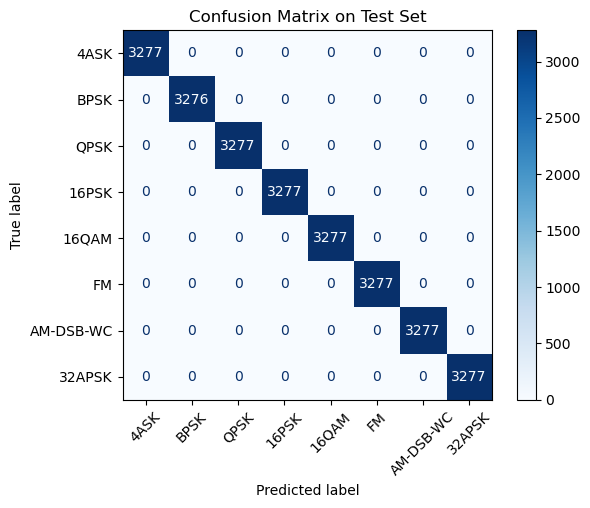

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# switch to eval mode and disable gradients
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)

        # forward pass
        outputs = model(xb)
        # get predicted class indices
        preds = outputs.argmax(dim=1).cpu().numpy()
        # gather everything
        all_preds.extend(preds)
        all_labels.extend(yb.cpu().numpy())

# compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# plot it
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=selected_mods  # your list of 8 class names
)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()


In [45]:
class HDF5RadioMLDataset(Dataset):
    def __init__(self, h5_path, selected_classes, base_classes, snr_count=1, train=True, test_ratio=0.2):
        self.h5_path = h5_path
        self.base_classes = base_classes
        self.selected_classes = selected_classes
        self.snr_count = snr_count
        self.samples_per_class = 106496
        self.samples_per_snr = 4096

        self.class_indices = [self.base_classes.index(c) for c in self.selected_classes]
        self.indices = []

        with h5py.File(self.h5_path, 'r') as f:
            for label, class_idx in enumerate(self.class_indices):
                start_idx = self.samples_per_class * (class_idx + 1) - self.samples_per_snr * self.snr_count
                end_idx = self.samples_per_class * (class_idx + 1)
                for i in range(start_idx, end_idx):
                    self.indices.append((i, label))

        # Train-test split
        np.random.seed(42)
        np.random.shuffle(self.indices)
        split = int(len(self.indices) * (1 - test_ratio))
        self.indices = self.indices[:split] if train else self.indices[split:]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i, label = self.indices[idx]
        with h5py.File(self.h5_path, 'r') as f:
            x = f['X'][i]  # shape: (2, 1024)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [46]:
base_classes = ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK',
                '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM',
                '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC',
                'FM', 'GMSK', 'OQPSK']
selected_classes = ['4ASK', 'BPSK', 'QPSK', '16PSK', '16QAM', 'FM', 'AM-DSB-WC', '32APSK']

train_dataset = HDF5RadioMLDataset(file_path, selected_classes, base_classes, snr_count=2, train=True)
test_dataset = HDF5RadioMLDataset(file_path, selected_classes, base_classes, snr_count=2, train=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [67]:
class CNNLSTMAMC(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        def conv_block():
            return nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3),    # → (B,64,30,30)
                nn.LeakyReLU(0.1),
                nn.Conv2d(64, 64, kernel_size=3),   # → (B,64,28,28)
                nn.LeakyReLU(0.1),
                nn.MaxPool2d(3, 2),                 # → (B,64,13,13)
                nn.Conv2d(64, 128, kernel_size=3),  # → (B,128,11,11)
                nn.LeakyReLU(0.1),
                nn.Conv2d(128, 128, kernel_size=3), # → (B,128,9,9)
                nn.LeakyReLU(0.1),
                nn.MaxPool2d(3, 2),                 # → (B,128,4,4)
            )
        self.i_path = conv_block()
        self.q_path = conv_block()

        # After two paths, flatten each into 2048, concat→4096
        self.lstm = nn.LSTM(
            input_size=4096,
            hidden_size=256,
            batch_first=True,
            dropout=0.5
        )
        self.fc_stack = nn.Sequential(
            nn.Linear(256, 1024), nn.LeakyReLU(0.1), nn.Dropout(0.5),
            nn.Linear(1024,1024), nn.LeakyReLU(0.1), nn.Dropout(0.5),
            nn.Linear(1024,1024), nn.LeakyReLU(0.1), nn.Dropout(0.5),
            nn.Linear(1024,256),  nn.LeakyReLU(0.1), nn.Dropout(0.5),
            nn.Linear(256,32),    nn.LeakyReLU(0.1),
            nn.Linear(32,num_classes)
        )

    def forward(self, x):
        # x: (B, 1024, 2)
        B = x.size(0)
        x = x.view(B, 32, 32, 2).permute(0,3,1,2)  # → (B,2,32,32)
        i = x[:,0:1]  # (B,1,32,32)
        q = x[:,1:2]  # (B,1,32,32)
        i_feat = self.i_path(i).reshape(B, -1)  # (B,2048)
        q_feat = self.q_path(q).reshape(B, -1)  # (B,2048)
        combined = torch.cat((i_feat, q_feat), dim=1).unsqueeze(1)  # (B,1,4096)
        lstm_out,_ = self.lstm(combined)                           # → (B,1,256)
        x = lstm_out.squeeze(1)                                    # (B,256)
        return self.fc_stack(x)                                    # (B,8)


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CNNLSTMAMC(num_classes=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

EPOCHS = 25

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)

    acc = correct / total
    print(f"Train Loss: {running_loss/len(train_loader):.4f} | Accuracy: {acc*100:.2f}%")


/home/lipplopp/anaconda3/envs/ai_sdr/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Using device: cuda


Epoch 1/25: 100%|██████████| 820/820 [00:34<00:00, 23.60it/s]


Train Loss: 1.0210 | Accuracy: 52.84%


Epoch 2/25: 100%|██████████| 820/820 [00:36<00:00, 22.60it/s]


Train Loss: 1.1541 | Accuracy: 48.53%


Epoch 3/25: 100%|██████████| 820/820 [00:37<00:00, 21.83it/s]


Train Loss: 1.3541 | Accuracy: 39.22%


Epoch 4/25: 100%|██████████| 820/820 [00:38<00:00, 21.47it/s]


Train Loss: 1.3154 | Accuracy: 41.76%


Epoch 5/25: 100%|██████████| 820/820 [00:37<00:00, 22.12it/s]


Train Loss: 2.0223 | Accuracy: 15.16%


Epoch 6/25: 100%|██████████| 820/820 [00:39<00:00, 21.00it/s]


Train Loss: 2.0806 | Accuracy: 12.44%


Epoch 7/25:  30%|██▉       | 245/820 [00:12<00:28, 20.26it/s]


KeyboardInterrupt: 

In [65]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)

test_acc = correct / total
print(f"\n🧪 Test Accuracy: {test_acc * 100:.2f}%")


🧪 Test Accuracy: 45.33%


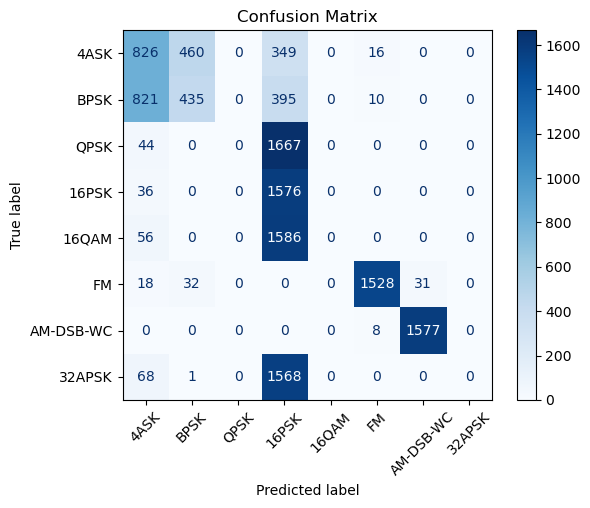

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=selected_mods)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
